In [51]:
import yfinance as yf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [52]:
data = yf.download('0005.hk',"2017-01-01","2021-12-30")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.250000,63.150002,62.200001,63.000000,50.812321,11331063
2017-01-04,63.450001,63.450001,62.950001,63.450001,51.175259,13426502
2017-01-05,63.799999,63.950001,63.549999,63.900002,51.538208,12484357
2017-01-06,63.900002,63.900002,63.349998,63.750000,51.417217,14321890
2017-01-09,63.599998,63.849998,63.299999,63.700001,51.376896,10499807


In [53]:
data['Prediction'] = data[['Close']].shift(-1)

In [54]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)

In [55]:
data.dropna(inplace=True)
data.drop('Adj Close',1,inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_14428/3402607050.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop('Adj Close',1,inplace=True)


In [56]:
data.head()

,Open,High,Low,Close,Volume,Prediction,6day MA,12day MA,RSI,%R5,%R10,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC6,OSC12
Date,,,,,,,,,,,,,,,,,,,
2017-02-21,69.000000,69.000000,65.400002,65.550003,106826895,65.449997,67.641668,67.087500,35.855058,-95.945901,-95.945901,-1.349998,-0.250000,67.057537,66.063836,1.019306,3.599998,-33.905212,-10.299996
2017-02-22,64.849998,65.750000,64.650002,65.449997,99295567,64.050003,67.383334,67.012500,35.164297,-82.022562,-82.022562,-1.550003,-0.900002,66.810223,66.018366,0.813523,1.099998,-35.305922,-11.521964
2017-02-23,63.950001,64.400002,63.900002,64.050003,37652154,63.549999,66.775002,66.833334,26.748087,-97.115354,-97.115354,-3.649994,-2.149994,66.385574,65.872561,0.531345,1.549995,-52.290845,-26.759273
2017-02-24,63.900002,63.950001,63.500000,63.549999,27069077,63.000000,65.983334,66.587501,24.322500,-99.107156,-99.107156,-4.750004,-2.950001,65.949332,65.700520,0.264324,0.550003,-57.116115,-31.364562
2017-02-27,63.000000,63.250000,62.750000,63.000000,37267733,62.500000,65.100000,66.320834,21.787035,-96.000000,-96.062991,-5.300003,-3.199997,65.495588,65.500481,0.008233,0.799999,-62.166930,-36.180027


In [57]:
data_price=data["Prediction"].values.reshape(-1,1)[:-15]
train=data.drop(['Prediction'],1).dropna().values[:-15]
sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))
train=sc_x.fit_transform(train)
data_price = sc_y.fit_transform(data_price)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb,len(data)-lb-1):
        X.append(data[i-(lb):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=10
X,y = processData(train,data_price,lb)
data_x=X[:-15]
data_y=y[:-15]
X_train,X_test = data_x[:int(data_x.shape[0]*0.90)],data_x[int(data_x.shape[0]*0.90):]
y_train,y_test = data_y[:int(data_y.shape[0]*0.90)],data_y[int(data_y.shape[0]*0.90):]
# print(type(X_train))
print(X.shape)
print(y.shape)

(1160, 10, 18)
(1160, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_14428/2467039408.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train=data.drop(['Prediction'],1).dropna().values[:-15]


In [58]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1030, 10, 18) (1030, 1) (115, 10, 18) (115, 1)


In [59]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape= (X_train.shape[1], X_train.shape[2]),recurrent_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [60]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                13800     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 10)               

In [61]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False,callbacks=es)

Epoch 1/300


2021-12-26 20:50:27.434420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 20:50:27.586703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/52 [====>.........................] - ETA: 0s - loss: 0.0741

2021-12-26 20:50:27.660065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 2s 19ms/step - loss: 0.0331 - val_loss: 9.3594e-04
Epoch 2/300
 5/52 [=>............................] - ETA: 0s - loss: 0.0306

2021-12-26 20:50:28.556563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 20:50:28.602899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 1s 14ms/step - loss: 0.0231 - val_loss: 0.0169
Epoch 3/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0345 - val_loss: 0.0131
Epoch 4/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0447 - val_loss: 0.0020
Epoch 5/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0343 - val_loss: 0.0014
Epoch 6/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0293 - val_loss: 0.0011
Epoch 7/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0275 - val_loss: 0.0012
Epoch 8/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0242 - val_loss: 0.0011
Epoch 9/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0226 - val_loss: 0.0012
Epoch 10/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0209 - val_loss: 0.0013
Epoch 11/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0209 - val_loss: 0.0012
Epoch 12/3

In [62]:
y_pred = model.predict(X_test)

2021-12-26 20:52:04.124076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 20:52:04.167552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [63]:
y_pred.shape

(115, 1)

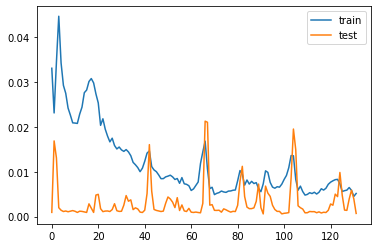

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

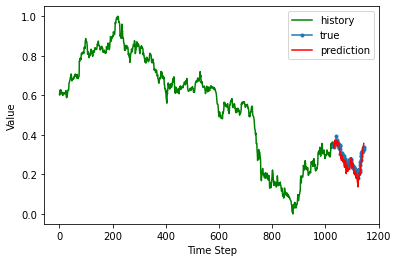

In [65]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [66]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test
y_test=sc_y.inverse_transform(y_test)
y_pred=sc_y.inverse_transform(y_pred)

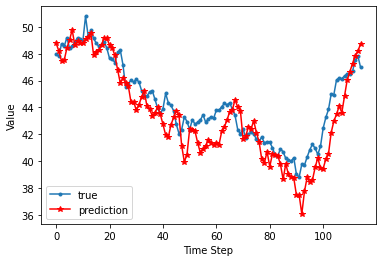

In [67]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [68]:
mean_absolute_percentage_error(y_test,y_pred)*100

2.8389800992005

In [69]:
mean_squared_error(y_test,y_pred)

2.346119072728755

In [70]:
r2_score(y_test,y_pred)

0.7314113974659183

# Unseen data

In [71]:
forecast_data = X[-15:]
forecast = y[-15:]
forecast=sc_y.inverse_transform(forecast) 
print(forecast)

[[47.15000153]
 [46.95000076]
 [47.04999924]
 [46.84999847]
 [47.15000153]
 [45.45000076]
 [45.70000076]
 [45.54999924]
 [45.29999924]
 [45.45000076]
 [45.29999924]
 [45.20000076]
 [45.79999924]
 [46.        ]
 [46.04999924]]


In [72]:
prediction = model.predict(forecast_data).reshape(-1,1)
prediction = sc_y.inverse_transform(prediction) 
print(prediction)

[[49.32323 ]
 [48.43826 ]
 [48.72622 ]
 [48.292744]
 [48.814583]
 [48.123375]
 [48.889355]
 [45.92977 ]
 [46.002716]
 [45.707325]
 [45.123463]
 [45.16126 ]
 [45.273014]
 [45.148464]
 [45.27152 ]]


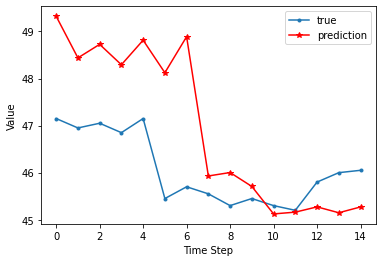

In [73]:
plt.plot(forecast, marker='.', label="true")
plt.plot(prediction, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [74]:
mean_absolute_percentage_error(forecast,prediction)*100

2.595425346912544

In [75]:
r2_score(forecast,prediction)

-3.3525298151146536